# Лабораторная работа № 2
## Выполнил: Яковлев Артур, 853501
## Проверил: Бутома В. С.

## Вариант 26

### Импорт библиотек

In [1]:
import typing as tp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from heapq import heappush, heappop
from numpy.random import exponential
from enum import Enum

### Реализация вспомогательных классов для моделирования

In [2]:
class EventType(Enum):
    Arrival = 1
    Service = 2
    Rejection = 3


class Event:
    def __init__(self, event_type: EventType, event_id: int, time: float, client: int) -> None:
        self.type = event_type
        self.channels_taken = 0
        self.event_id = event_id
        self.time = time
        self.client = client

    def __lt__(self, other) -> bool:
        return self.time < other.time

    def __hash__(self) -> int:
        return hash((self.event_id, self.time, self.client))

    def __str__(self) -> str:
        return f'type={self.type} id={self.event_id} time={self.time} client={self.client}'

    def __repr__(self) -> str:
        return str(self)

In [3]:
class ExponentialGenerator:
    def __init__(self, param: float) -> None:
        self.param = 1. / param

    def __iter__(self) -> 'ExponentialGenerator':
        return self

    def __next__(self) -> float:
        return exponential(self.param)

In [4]:
class EventQueue:
    def __init__(self) -> None:
        self.events: tp.Set[Event] = set()
        self.client_to_event: tp.Dict[int, Event] = {}
        self.heap: tp.List[Event] = []

    def push(self, event: Event) -> None:
        heappush(self.heap, event)
        self.client_to_event[event.client] = event
        self.events.add(event)

    def pop(self) -> tp.Optional[Event]:
        while not self.empty():
            event = heappop(self.heap)
            if event in self.events:
                self.events.remove(event)
                self.client_to_event.pop(event.client)
                return event

    def remove(self, client: int) -> None:
        self.events.remove(self.client_to_event[client])
        self.client_to_event.pop(client)

    def clear(self) -> None:
        self.heap.clear()

    def empty(self) -> bool:
        return len(self.heap) == 0

    def __len__(self) -> int:
        return len(self.heap)

    def __str__(self) -> str:
        return str(self.heap)

    def __repr__(self) -> str:
        return str(self)

### Реализация симулятора

In [70]:
class ChannelCoopSimulator:
    def __init__(
            self,
            channels: int,
            arrival_rate: float,
            max_request_channels: int,
            service_function: tp.Callable[[int], float]
    ) -> None:
        self.channels = channels
        assert arrival_rate > 0
        self.arrival_rate = arrival_rate
        self.arrival_generator = ExponentialGenerator(arrival_rate)
        self.service_function = service_function
        self.max_request_channels = max_request_channels
        self.event_queue = EventQueue()
        self.successes = 0
        self.states = np.zeros(channels + 1, dtype='float64')

    def __call__(self, max_time: float) -> None:
        self.event_queue.clear()
        self.event_queue.push(Event(EventType.Arrival, 0, next(self.arrival_generator), 0))
        self.states.fill(0)
        clients_count = 1
        busy_channels = 0
        events_count = 1
        current_time = 0.
        while current_time < max_time:
            event = self.event_queue.pop()
            state = busy_channels
            self.states[state] += event.time - current_time
            current_time = event.time
            if event.type is EventType.Arrival:
                if busy_channels < self.channels:
                    current_channels = min(busy_channels + self.max_request_channels, self.channels) - busy_channels
                    busy_channels += current_channels
                    new_event = Event(
                        EventType.Service,
                        events_count,
                        current_time + next(ExponentialGenerator(self.service_function(current_channels))),
                        event.client
                    )
                    new_event.channels_taken = current_channels
                    self.event_queue.push(new_event)
                    events_count += 1
                    if busy_channels < self.channels:
                        self.event_queue.push(Event(
                            EventType.Arrival,
                            events_count,
                            current_time + next(self.arrival_generator),
                            clients_count
                        ))
                        events_count += 1
                        clients_count += 1
                        
                else:
                    pass
                    # raise ValueError('Something went wrong: trying to add customer with full queue')
            elif event.type is EventType.Service:
                if busy_channels == self.channels:
                    self.event_queue.push(Event(
                        EventType.Arrival,
                        events_count,
                        current_time + next(self.arrival_generator),
                        clients_count
                    ))
                    events_count += 1
                    clients_count += 1
                busy_channels -= event.channels_taken
    
    def evaluate(self) -> tp.Tuple[np.ndarray, int, int]:
        if np.sum(self.states) == 0:
            raise ValueError('Simulation has not been running or no events happened')
        return self.states / np.sum(self.states)

    def get_system_stats(self, probas: np.ndarray) -> tp.Dict[str, tp.Any]:
        rejection_proba = probas[-1]
        Q = 1 - rejection_proba
        A = self.arrival_rate * Q
        avg_busy_channels = np.arange(self.channels) @ probas[1:]
        return [rejection_proba, A, avg_busy_channels]

### Визуализация результатов моделирования

In [61]:
def plot_hists(simulator_regular: ChannelCoopSimulator, simulator_coop: ChannelCoopSimulator) -> None:
    probas_regular = simulator_regular.evaluate()
    probas_coop = simulator_coop.evaluate()
    fig, axes= plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.barplot(x=np.arange(len(probas_regular)), y=probas_regular, ax=axes[0])
    sns.barplot(x=np.arange(len(probas_coop)), y=probas_coop, ax=axes[1])
    fig.suptitle('State probabilities', fontsize=18)

    axes[0].set_title('Model without channel cooperation')
    axes[0].set_xlabel('State')
    axes[0].set_ylabel('Probability')

    axes[1].set_xlabel('State')
    axes[1].set_ylabel('Probability')
    axes[1].set_title(f'Model with cooperation for {simulator_coop.max_request_channels} channels')
    plt.show()

In [62]:
def stats_dataframes(simulator_regular: ChannelCoopSimulator, simulator_coop: ChannelCoopSimulator) -> pd.DataFrame:
    rows = np.array(['Вероятность отказа', 'Абсолютная пропускная способность', 'Среднее число занятых каналов']).reshape(-1, 1)
    columns = ['Характеристика', 'Система без взаимодействия каналов', 'Система со взаимодействием каналов']
    regular_stats = np.array(simulator_regular.get_system_stats(simulator_regular.evaluate())).reshape(-1, 1)
    coop_stats = np.array(simulator_coop.get_system_stats(simulator_coop.evaluate())).reshape(-1, 1)
    return pd.DataFrame(np.hstack((rows, regular_stats, coop_stats)), columns=columns).style.hide_index()

In [63]:
def conduct_experiment(channels: int, arrival_rate: float, max_channels: int, aggregation_function: tp.Callable[[int], float], 
                       simulation_time: float = 10000.)-> pd.DataFrame:
    simulator_regular = ChannelCoopSimulator(channels, arrival_rate, 1, lambda x: x)
    simulator_regular(simulation_time)
    simulator_coop = ChannelCoopSimulator(channels, arrival_rate, max_channels, aggregation_function)
    simulator_coop(simulation_time)
    plot_hists(simulator_regular, simulator_coop)
    return stats_dataframes(simulator_regular, simulator_coop)

### Эксперименты

Возьмем самую простую зависимость интенсивности потока обслуживания от числа каналов $y=x$ и проверим влияние максимального количества каналов, которые могут обрабатывать одну заявку

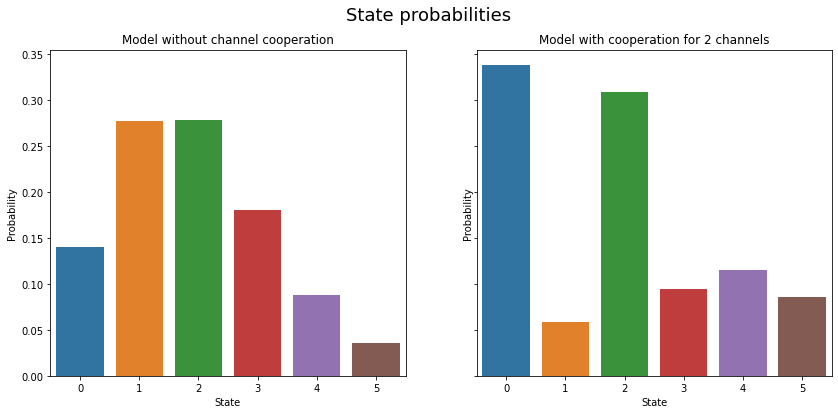

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03578377023567836,0.08526759950789725
Абсолютная пропускная способность,1.9284324595286433,1.8294648009842054
Среднее число занятых каналов,1.046740791880843,1.182535835666771


In [81]:
conduct_experiment(5, 2., 2, lambda x: x)

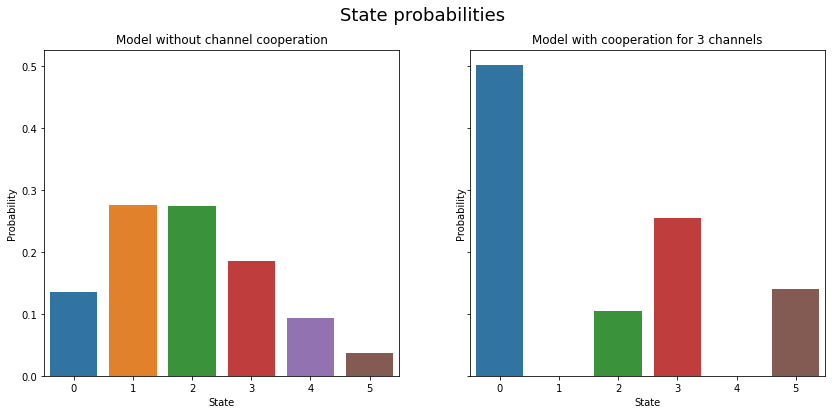

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03721838862003408,0.13942001487566197
Абсолютная пропускная способность,1.9255632227599317,1.7211599702486762
Среднее число занятых каналов,1.071046010828653,1.1709634404200755


In [82]:
conduct_experiment(5, 2., 3, lambda x: x)

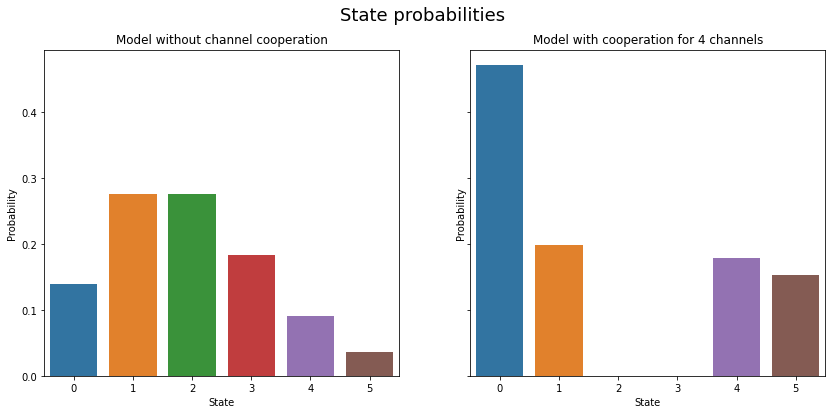

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03636625312889655,0.1523481841178699
Абсолютная пропускная способность,1.927267493742207,1.6953036317642602
Среднее число занятых каналов,1.0596602928734984,1.1441143537574745


In [83]:
conduct_experiment(5, 2., 4, lambda x: x)

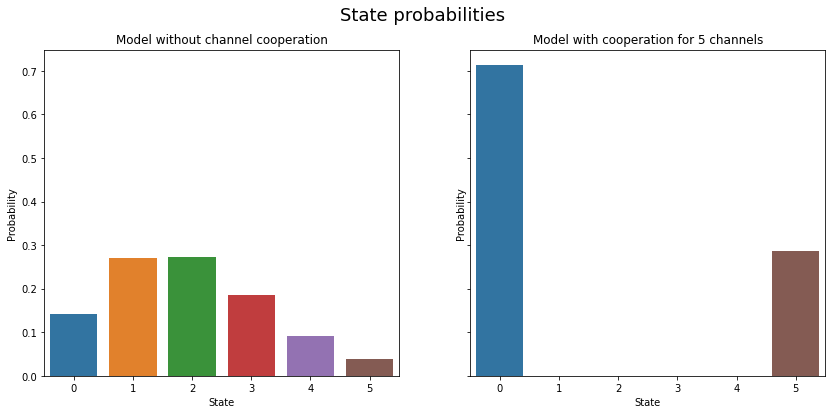

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03755964847615623,0.28690805092880334
Абсолютная пропускная способность,1.9248807030476875,1.4261838981423933
Среднее число занятых каналов,1.06848674862434,1.1476322037152134


In [84]:
conduct_experiment(5, 2., 5, lambda x: x)

Можем сделать вывод, что при максимальном количестве каналов сравнимом с общим количеством характеристики системы ухудшаются: заявки занимают больше каналов и временно останавливают обработку новых заявок, в связи с чем растет число отказов

Попробуем улучшить результаты при взаимодействии каналов, выбрав другую функцию зависимости интенсивности потока обслуживания от числа каналов, например $2x$

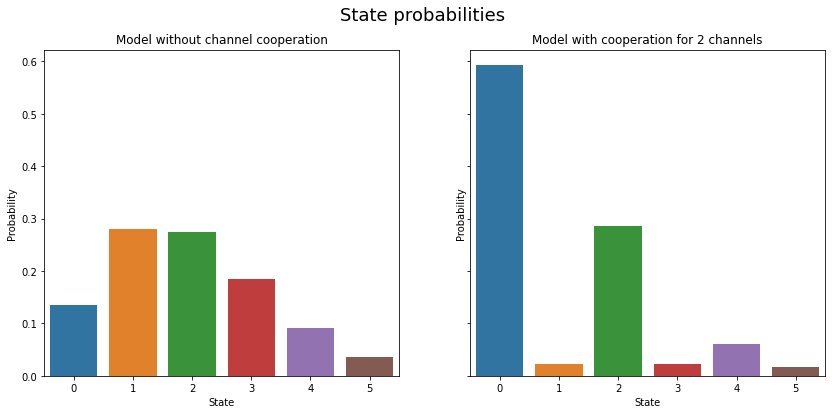

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03594498517753454,0.016140669874206436
Абсолютная пропускная способность,1.928110029644931,1.967718660251587
Среднее число занятых каналов,1.0569490731975582,0.5772673876576835


In [85]:
conduct_experiment(5, 2., 2, lambda x: 2 * x)

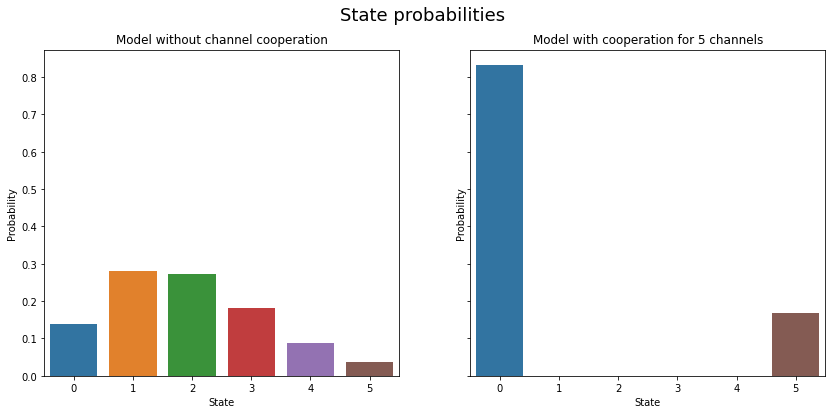

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03639534230205416,0.16806073673142108
Абсолютная пропускная способность,1.9272093153958916,1.6638785265371578
Среднее число занятых каналов,1.0468928651570901,0.6722429469256843


In [86]:
conduct_experiment(5, 2., 5, lambda x: 2 * x)

С такой функцией уменьшается матожидание времени обработки относительно системы без взаимодействия, что при небольшом количестве взаимодействующих каналов позволяет получить преимущество

Проведем эксперименты с нелинейными функциями

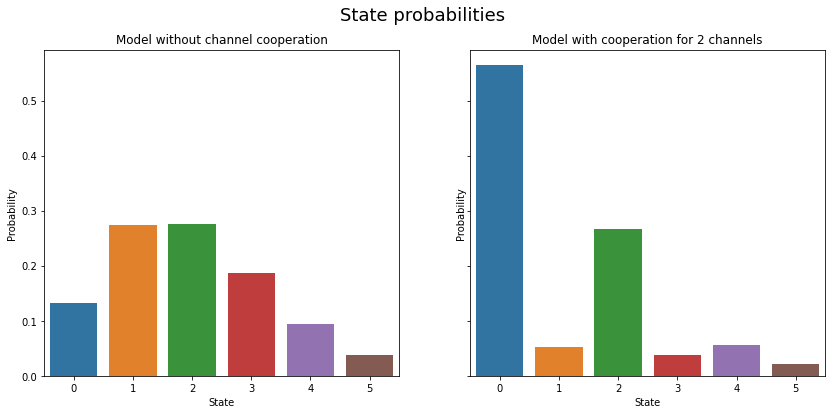

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03741079546966607,0.021775092841680083
Абсолютная пропускная способность,1.9251784090606678,1.9564498143166398
Среднее число занятых каналов,1.0814040614982228,0.5975341020946275


In [88]:
conduct_experiment(5, 2., 2, lambda x: x ** 2)

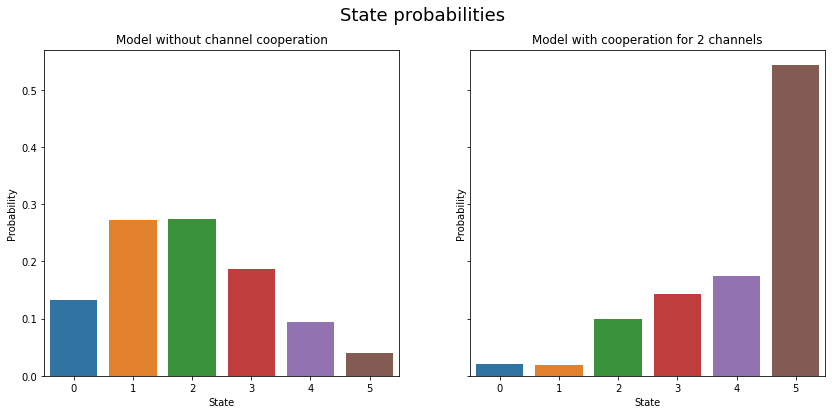

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.040042001905109016,0.5429451514547741
Абсолютная пропускная способность,1.919915996189782,0.9141096970904519
Среднее число занятых каналов,1.0878115773243415,3.0831511695576177


In [89]:
conduct_experiment(5, 2., 2, lambda x: 1 / (1 + x))

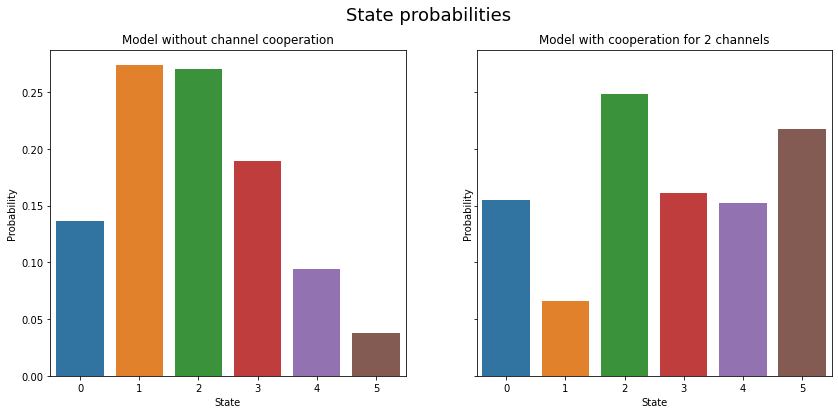

Характеристика,Система без взаимодействия каналов,Система со взаимодействием каналов
Вероятность отказа,0.03729969329559874,0.2177302702271669
Абсолютная пропускная способность,1.9254006134088024,1.5645394595456663
Среднее число занятых каналов,1.0786264223405073,1.898351468628434


In [90]:
conduct_experiment(5, 2., 2, lambda x: np.log1p(x))